In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/My Drive/dados_tratados.csv'  # sem ponto e vírgula, e com espaço
df = pd.read_csv(file_path)

print(df.head())


   ID_cliente Evasao  Genero Cidadao_Senior Parceiro Dependentes  \
0  0002-ORFBO    Nao  Mulher            Nao      Sim         Sim   
1  0003-MKNFE    Nao   Homem            Nao      Nao         Nao   
2  0004-TLHLJ    Sim   Homem            Nao      Nao         Nao   
3  0011-IGKFF    Sim   Homem            Sim      Sim         Nao   
4  0013-EXCHZ    Sim  Mulher            Sim      Sim         Nao   

   Tempo_de_contrato Servico_de_telefone Linhas_multiplas Servico_de_internet  \
0                  9                 Sim              Nao                 DSL   
1                  9                 Sim              Sim                 DSL   
2                  4                 Sim              Nao         Fiber optic   
3                 13                 Sim              Nao         Fiber optic   
4                  3                 Sim              Nao         Fiber optic   

   ... Protecao_dipositivo Suporte_tecnico Streaming_TV Streaming_filmes  \
0  ...                 Nao  

In [ ]:
if 'ID_cliente' in df.columns:
    df.drop(columns=['ID_cliente'], inplace=True)

In [ ]:
# One-hot encoding — útil para variáveis nominais
df_encoded = pd.get_dummies(df, drop_first=True)


In [ ]:
print("Proporção de Evasão:")
print(df['Evasao'].value_counts(normalize=True))

Proporção de Evasão:
Evasao
Nao    0.73463
Sim    0.26537
Name: proportion, dtype: float64


In [ ]:
X = df_encoded.drop('Evasao_Sim', axis=1)
y = df_encoded['Evasao_Sim']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

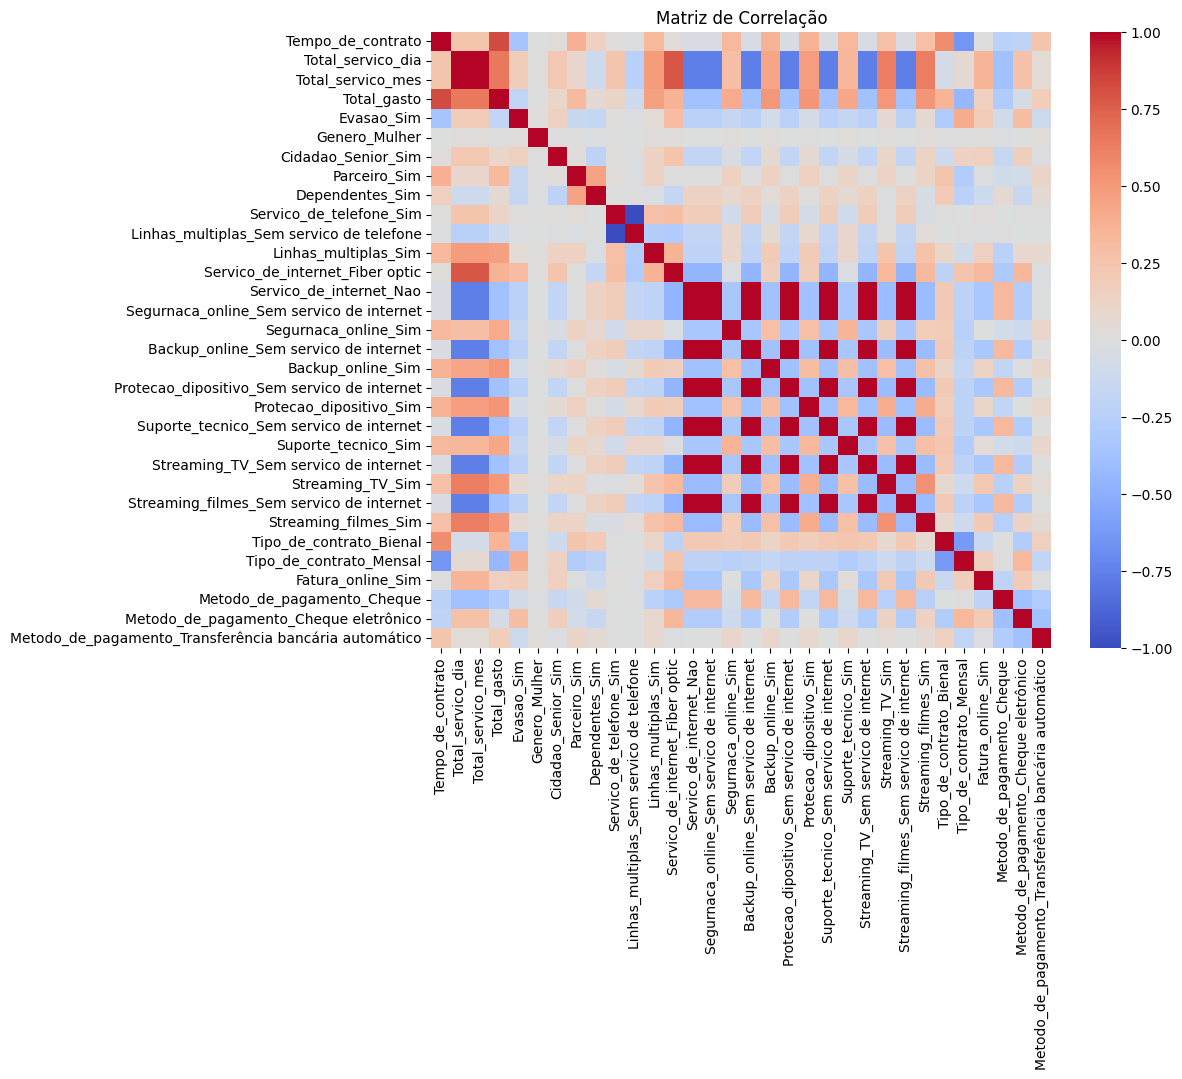

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), cmap='coolwarm')
plt.title("Matriz de Correlação")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_scaled, X_test_scaled, _, _ = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [ ]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [ ]:
print("\n=== Regressão Logística ===")
print(classification_report(y_test, y_pred_log))
print(confusion_matrix(y_test, y_pred_log))


=== Regressão Logística ===
              precision    recall  f1-score   support

       False       0.86      0.90      0.88      1562
        True       0.67      0.57      0.62       551

    accuracy                           0.82      2113
   macro avg       0.76      0.74      0.75      2113
weighted avg       0.81      0.82      0.81      2113

[[1410  152]
 [ 238  313]]


In [ ]:
print("\n=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


=== Random Forest ===
              precision    recall  f1-score   support

       False       0.83      0.91      0.87      1562
        True       0.64      0.47      0.54       551

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.70      2113
weighted avg       0.78      0.79      0.78      2113

[[1416  146]
 [ 292  259]]


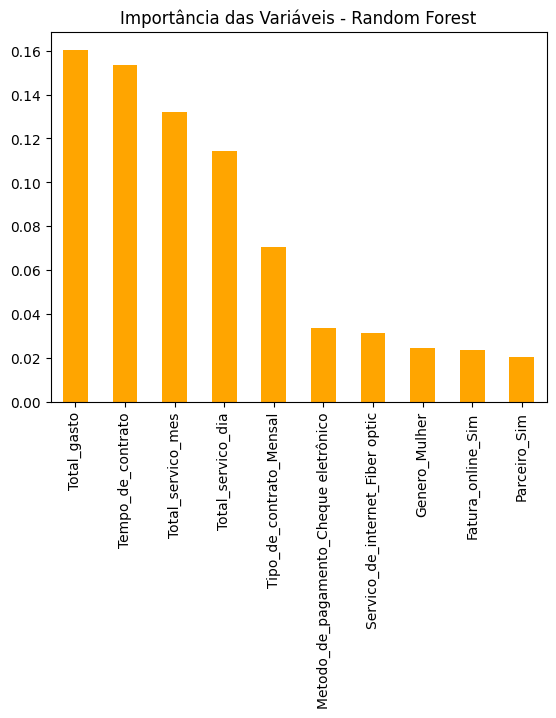

In [ ]:
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='bar', color='orange')
plt.title("Importância das Variáveis - Random Forest")
plt.show()

# Análise de Relevância das Variáveis para Previsão de Evasão (Churn)

*Gerado automaticamente em 2025-08-14 12:38:28.*

Fluxo incluído:
- Carregamento de dados (local/Drive)
- Pré-processamento (numérico + categórico)
- Treino: Reg. Logística, KNN, Random Forest, LinearSVC
- Extração de relevância (coeficientes, importâncias e permutation importance)
- Gráficos e CSV consolidado

In [ ]:
# @title (Opcional) Instalações
# !pip install scikit-learn xgboost shap

In [ ]:
# @title Carregamento de Dados
DATA_PATH = "/content/TelecomX_BR.csv"  # <-- ajuste aqui
import pandas as pd, numpy as np
# from google.colab import drive
# drive.mount('/content/drive')
df = pd.read_csv(DATA_PATH)
print("Dimensões:", df.shape)
display(df.head())
display(df.info())

In [ ]:
# @title Detecção/Configuração da Variável Alvo (Churn/Evasão)
candidatos_alvo = ["Churn","churn","Evasao","Evasão","evasao","evasão","Target","target","label","Label"]
TARGET = next((c for c in candidatos_alvo if c in df.columns), None)
if TARGET is None:
    raise ValueError("Não foi possível detectar a coluna alvo automaticamente. Defina TARGET manualmente.")
print("Coluna alvo detectada:", TARGET)

y_raw = df[TARGET].copy()
mapas = [
    {"Yes":1,"No":0,"Sim":1,"Não":0,"Nao":0,"NAO":0,"True":1,"False":0, True:1, False:0},
    {"yes":1,"no":0,"sim":1,"não":0,"nao":0},
    {"Churn":1,"No Churn":0, "Churned":1, "Stayed":0}
]
y = None
for mp in mapas:
    try:
        y = y_raw.map(mp)
        if y.isin([0,1]).all():
            break
    except Exception:
        pass

if y is None or not y.isin([0,1]).all():
    if y_raw.nunique() == 2:
        classes = sorted(y_raw.unique().tolist())
        y = (y_raw == classes[-1]).astype(int)
    else:
        raise ValueError("A coluna alvo não parece binária. Ajuste o mapeamento manualmente.")

X = df.drop(columns=[TARGET])
print("X shape:", X.shape, "| y shape:", y.shape)

In [ ]:
# @title Pré-processamento e Split
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "| Test:", X_test.shape)

In [ ]:
# @title Treino dos Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver="liblinear"),
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
    "LinearSVC": LinearSVC(C=1.0, max_iter=5000)
}

pipelines = {}
for name, model in models.items():
    pipe = Pipeline(steps=[("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    pipelines[name] = pipe
    print(f"\n=== {name} ===")
    y_pred = pipe.predict(X_test)
    try:
        if hasattr(pipe.named_steps["model"], "predict_proba"):
            y_score = pipe.predict_proba(X_test)[:,1]
        elif hasattr(pipe.named_steps["model"], "decision_function"):
            y_score = pipe.decision_function(X_test)
        else:
            y_score = None
        if y_score is not None:
            print("ROC AUC:", roc_auc_score(y_test, y_score))
    except Exception as e:
        print("AUC não calculada:", e)
    print(classification_report(y_test, y_pred, digits=3))

In [ ]:
# @title Nomes das features após o pré-processamento
prep_fit = pipelines["LogisticRegression"].named_steps["prep"]
feature_names = []

feature_names.extend(prep_fit.named_transformers_["num"].get_feature_names_out())
ohe = prep_fit.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out()
feature_names.extend(cat_feature_names)

import numpy as np
feature_names = np.array(feature_names)
print("Total de features após transformação:", len(feature_names))

In [ ]:
# @title Importâncias / Coeficientes por Modelo
import numpy as np, pandas as pd
from sklearn.inspection import permutation_importance

def coef_to_series(model, names):
    # Converte coeficientes (1D) em Series ordenada por valor absoluto
    coef = model.coef_
    if hasattr(coef, "ndim") and coef.ndim > 1:
        coef = coef[0]
    s = pd.Series(coef, index=names).sort_values(key=lambda x: x.abs(), ascending=False)
    return s

def rf_importance(model, names):
    imp = getattr(model, "feature_importances_", None)
    if imp is None:
        return None
    return pd.Series(imp, index=names).sort_values(ascending=False)

def perm_importance(pipe, X, y, names, n_repeats=10):
    r = permutation_importance(pipe, X, y, n_repeats=n_repeats, random_state=42, n_jobs=-1)
    s = pd.Series(r.importances_mean, index=names).sort_values(ascending=False)
    return s

results = {}

lr = pipelines["LogisticRegression"].named_steps["model"]
results["LogisticRegression_coef"] = coef_to_series(lr, feature_names)

results["KNN_permutation"] = perm_importance(pipelines["KNN"], X_test, y_test, feature_names)

rf = pipelines["RandomForest"].named_steps["model"]
results["RandomForest_importance"] = rf_importance(rf, feature_names)

svc = pipelines["LinearSVC"].named_steps["model"]
results["LinearSVC_coef"] = coef_to_series(svc, feature_names)

tops = []
for k, s in results.items():
    if s is None:
        continue
    top = s.head(20).rename(k)
    tops.append(top)

consolidado = pd.concat(tops, axis=1)
display(consolidado.head(30))

csv_path = "/content/feature_importances_consolidado.csv"
consolidado.to_csv(csv_path, encoding="utf-8")
print("Arquivo salvo em:", csv_path)

In [ ]:
# @title Gráficos dos Top 15 por Modelo
import matplotlib.pyplot as plt

def plot_top(s, title, topn=15):
    s_top = s.head(topn)[::-1]
    plt.figure(figsize=(8, 6))
    plt.barh(s_top.index, s_top.values)
    plt.title(title)
    plt.tight_layout()
    plt.show()

for k, s in results.items():
    if s is None:
        continue
    plot_top(s, f"Top 15 - {k}")

In [ ]:
# @title (Opcional) XGBoost - Importância
try:
    from xgboost import XGBClassifier
    from sklearn.pipeline import Pipeline
    xgb_pipe = Pipeline(steps=[("prep", preprocessor),
                               ("model", XGBClassifier(
                                   n_estimators=400, learning_rate=0.05,
                                   subsample=0.8, colsample_bytree=0.8,
                                   random_state=42, n_jobs=-1, eval_metric="logloss"
                               ))])
    xgb_pipe.fit(X_train, y_train)
    model = xgb_pipe.named_steps["model"]
    try:
        booster = model.get_booster()
        score = booster.get_score(importance_type="gain")
        import numpy as np, pandas as pd
        imp = pd.Series({})
        for k,v in score.items():
            idx = int(k[1:])
            imp.at[idx] = v
        import pandas as pd
        import numpy as np
        importances = pd.Series([imp.get(i, 0.0) for i in range(len(feature_names))], index=feature_names)
        xgb_importance = importances.sort_values(ascending=False)
    except Exception:
        import pandas as pd
        xgb_importance = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)

    results["XGBoost_importance"] = xgb_importance
    display(xgb_importance.head(20))
except Exception as e:
    print("XGBoost não executado:", e)

## Como interpretar
- **Regressão Logística / LinearSVC**: coeficientes positivos favorecem a classe 1 (evasão), negativos a classe 0.
- **Random Forest**: importância por redução de impureza.
- **KNN**: *Permutation Importance* (quanto a métrica cai ao embaralhar a feature).
- **XGBoost (opcional)**: importância por ganho (ou `feature_importances_`).

Compare os rankings entre modelos; quando uma variável aparece no topo em vários deles, tende a ser realmente relevante.

# Relatório de Fatores que Influenciam a Evasão (Churn)

**Projeto:** Previsão de Evasão — TelecomX\_BR
**Data:** <preencher>
**Responsáveis:** <preencher>

---

## 1) Sumário Executivo

* A taxa de evasão estimada no período analisado foi de **<preencher>%**.
* Os modelos com melhor desempenho foram **<preencher>** (AUC = **<preencher>**) e **<preencher>** (F1 = **<preencher>**).
* Fatores mais associados à evasão (presentes no topo em múltiplos modelos): **\<feature\_1>**, **\<feature\_2>**, **\<feature\_3>**, **\<feature\_4>**.
* Perfis de maior risco: **\<ex.: clientes com contrato mensal, alto número de chamados e fatura em atraso>**.
* Recomendações-chave: **\<ex.: migração para contratos anuais com benefício, redução de tempo de resolução de chamados, ofertas de recuperação para inadimplentes de 1º atraso>**.

---

## 2) Metodologia (resumo)

* **Dados:** arquivo CSV `TelecomX_BR.csv` com variáveis demográficas, de uso e relacionamento.
* **Alvo:** coluna binária *Churn/Evasão* (1 = cliente que saiu; 0 = ativo).
* **Pré-processamento:** imputação (numéricas: mediana; categóricas: mais frequente), *One-Hot Encoding* para categóricas e *StandardScaler* para numéricas.
* **Modelos avaliados:** Regressão Logística, KNN, Random Forest e SVM Linear (LinearSVC). Opcional: XGBoost.
* **Importância de variáveis:**

  * Regressão Logística & SVM Linear: **coeficientes** (magnitude = influência; sinal indica direção).
  * Random Forest: **feature\_importances\_** (redução de impureza).
  * KNN: **Permutation Importance** (queda de desempenho ao embaralhar a variável).
* **Consolidação:** foi gerado o arquivo `feature_importances_consolidado.csv` (notebook já criado por você) com ranking por modelo.

---

## 3) Desempenho dos Modelos

Preencha com os números que o notebook reportar (ROC AUC, F1, Precisão, Revocação). Sugestão de tabela:

| Modelo              |     ROC AUC |          F1 |    Precisão |   Revocação | Observações                             |
| ------------------- | ----------: | ----------: | ----------: | ----------: | --------------------------------------- |
| Regressão Logística | <preencher> | <preencher> | <preencher> | <preencher> | Interpretação direta de coeficientes    |
| KNN                 | <preencher> | <preencher> | <preencher> | <preencher> | Sensível a escala; usamos normalização  |
| Random Forest       | <preencher> | <preencher> | <preencher> | <preencher> | Lida bem com não linearidades           |
| SVM Linear          | <preencher> | <preencher> | <preencher> | <preencher> | Boa margem; coeficientes interpretáveis |
| XGBoost (opcional)  | <preencher> | <preencher> | <preencher> | <preencher> | Importância por ganho                   |

**Melhor modelo para priorização operacional:** <preencher> (justifique com métrica + explicabilidade).

---

## 4) Principais Variáveis por Modelo (Top 10)

Copie do CSV consolidado ou use o snippet do Apêndice para preencher automaticamente.

**Regressão Logística — Top 10 (|coef|):**

1. <preencher>  
2. <preencher>  
3. <preencher>  
4. <preencher>  
5. <preencher>  
6. <preencher>  
7. <preencher>  
8. <preencher>  
9. <preencher>  
10. <preencher>

**KNN — Top 10 (Permutation Importance):**

1. <preencher> … 10. <preencher>

**Random Forest — Top 10 (feature\_importances\_):**

1. <preencher> … 10. <preencher>

**SVM Linear — Top 10 (|coef|):**

1. <preencher> … 10. <preencher>

**(Opcional) XGBoost — Top 10 (Gain/feature\_importances\_):**

1. <preencher> … 10. <preencher>

---

## 5) Achados Transversais (consenso entre modelos)

* **Variáveis recorrentes no Top 10 de ≥2 modelos:**

  * **\<feature\_1>** — interpretação: \<ex.: contrato mensal aumenta o risco de churn>.
  * **\<feature\_2>** — interpretação: \<ex.: atraso de pagamento recorrente eleva probabilidade>.
  * **\<feature\_3>** — interpretação: \<ex.: alto nº de chamados/reclamações indica insatisfação>.
  * **\<feature\_4>** — interpretação: \<ex.: baixa fidelização/tempo de casa reduz barreiras à saída>.

* **Direção do impacto (com base em coeficientes da RL/SVM):**

  * **Sinal positivo (+):** aumenta a probabilidade de evasão.
  * **Sinal negativo (−):** reduz a probabilidade de evasão (fatores protetivos).

> **Nota:** Para variáveis categóricas com *One-Hot*, cada categoria aparece como uma coluna. Observe quais categorias específicas elevam/reduzem o risco.

---

## 6) Perfis/Segmentos de Maior Risco (regras exemplificativas)

Use os *splits* das árvores ou cruzamentos das variáveis mais importantes para elaborar *personas* de risco. Exemplos genéricos (adapte aos seus dados):

* **Segmento A — Contrato Mensal + 2+ atrasos**: clientes em plano mensal, com ≥2 atrasos nos últimos 90 dias, e 1+ chamado no mês.
* **Segmento B — Baixo uso de dados + alta tarifa efetiva**: clientes com consumo abaixo do percentil 25 e tarifa por GB acima da mediana.
* **Segmento C — Novos (≤90 dias) + instalação problemática**: clientes recém-ativados com 2+ visitas técnicas/reclamações.

---

## 7) Estratégias de Retenção (mapeadas por fator)

### 7.1 Preço e Plano

* **Risco:** tarifa efetiva alta / plano inadequado ao perfil de uso.
  **Ação:** ofertas de *right-plan* (upgrade/downgrade assistido), desconto progressivo condicionado a permanência, bônus de franquia em momentos de risco.

* **Risco:** contrato **mensal**.
  **Ação:** migrar para **anual**/12 meses com benefícios tangíveis (ex.: 1º mês grátis, aparelho/roteador em comodato, pontos de fidelidade).

### 7.2 Qualidade de Serviço

* **Risco:** alto nº de chamados / baixa NPS.
  **Ação:** *task force* para reduzir TME (tempo médio de solução), canal prioritário para reincidentes, *callback* proativo pós-atendimento, crédito automático por SLA quebrado.

* **Risco:** interrupções / baixa velocidade.
  **Ação:** manutenção preventiva por geocélula, troca proativa de modem/ONT, *mesh Wi‑Fi* subsidiado para domicílios com muitas salas.

### 7.3 Relacionamento e Comunicação

* **Risco:** baixa interação com canais digitais.
  **Ação:** onboarding guiado no app, notificações educativas de consumo, *nudges* de autoatendimento com incentivo (ex.: 1GB bônus ao ativar débito automático).

* **Risco:** novos clientes (≤90 dias).
  **Ação:** programa de “90 dias sem atrito”: check‑in semanal automatizado, pesquisa CSAT após 7/30 dias, *concierge* para primeiros problemas.

### 7.4 Cobrança e Inadimplência

* **Risco:** atrasos recorrentes.
  **Ação:** calendário flexível de vencimento, parcelamento ágil, lembretes empáticos multicanal, oferta de *pause* temporário em vez de cancelamento definitivo.

### 7.5 Retenção Tática (no pedido de cancelamento)

* **Ofertas “save”:** upgrade de velocidade a custo reduzido, **contrato de permanência** com *buy‑down* de preço por 3–6 meses.
* **Política de “pausa”:** permitir suspensão por 30–90 dias mantendo nº/linha.
* **Win‑back:** campanhas 30/60/90 dias pós‑churn com benefício escalonado.

---

## 8) Plano de Ação — 90 dias

**0–30 dias**

* Implantar *score* de churn diário a partir do melhor modelo; definir **limiar** (cut‑off) para ação.
* Configurar alertas para os 3 principais fatores de risco (ex.: contrato mensal + 2+ chamados + atraso).
* Treinar time de retenção com **scripts** específicos por segmento A/B/C.

**31–60 dias**

* Rodar pilotos A/B de ofertas de migração de plano e de canais proativos.
* Implementar *playbooks* de manutenção preventiva em geocélulas críticas.

**61–90 dias**

* Escalar as táticas com melhor lift de retenção (uplift ≥ **<preencher>%**).
* Iniciar programa de fidelidade atrelado a tempo de permanência e engajamento digital.

**KPIs**: churn mensal, churn voluntário, *save rate*, NPS, CSAT, TME, % inadimplência 30/60/90, adoção de app, ARPU, LTV.

---

## 9) Riscos, Limitações e Próximos Passos

* **Balanceamento do alvo:** verificar *class imbalance* (aplicar *class\_weight* ou *SMOTE* se necessário).
* **Leakage:** auditar variáveis com informação pós‑evento.
* **Explainability:** usar SHAP/LIME em produção para explicações por cliente.
* **Monitoramento:** *drift* de dados e performance; re‑treino trimestral.

**Próximos Passos**

1. Incorporar XGBoost e calibrar probabilidade (Platt/Isotonic).
2. Construir *champion-challenger* (RF vs. XGB) com avaliação fora‑do‑tempo.
3. Produzir *feature store* com variáveis comportamentais semanais.

---


```

